In [1]:
import os
import time
from datetime import datetime
from pathlib import Path

import akshare as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import snoop
from pylab import legend
from snoop import pp

%matplotlib inline

In [2]:
fund_code = '510500'
init_cash = init_shares = cash = 100000
(
    f_buy_point,
    ss_buy_point,
    s_buy_point,
    buy_point,
    sell_point,
    s_sell_point,
    ss_sell_point,
    f_sell_point,
) = (0.005, 0.05, 0.15, 0.25, 0.7, 0.8, 0.9, 0.995)
fund_cache_file = f'../test-cached/open_fund/{fund_code}.csv'

In [3]:
# @snoop
def is_gt_24hours(early_dt, later_dt):
    return (later_dt - early_dt).days >= 1


def cache_fund_to_csv(fund_code, filename):
    open_fund_df = ak.fund_open_fund_info_em(fund=fund_code, indicator="单位净值走势")
    open_fund_df.to_csv(filename, index_label='index')


def recent_10_years(df):
    r_10_df = df.tail(10 * 12)
    # result_df = r_11_df.iloc[1:] #去除第一行异常数据
    return r_10_df.reset_index()


def get_cached_fund_df(fund_code, cached_file):
    if not Path(cached_file).exists():
        cache_fund_to_csv(fund_code, cached_file)

    cached_file_dt = datetime.fromtimestamp(os.stat(cached_file).st_mtime)

    if is_gt_24hours(cached_file_dt, datetime.now()):
        cache_fund_to_csv(fund_code, cached_file)

    date_parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d')
    return pd.read_csv(
        cached_file, parse_dates=['净值日期'], index_col=['净值日期'], date_parser=date_parser
    )


def pre_process(df):
    df.drop(columns=['index', '日增长率'], inplace=True)
    return df.resample("MS").first()


def ten_years_pct_change(df):
    recent_one_year_s = df['单位净值'].pct_change(periods=12)

    result_df = df.copy()
    result_df['近一年增长'] = recent_one_year_s

    # 处理前12行没有数据的问题
    # result_df.loc[0, '近一年增长'] = 0
    # for i in range(12):
    #     result_df.loc[i + 1, '近一年增长'] = (df.loc[i + 1, '单位净值'] / df.loc[0, '单位净值']) - 1
    return result_df


def recacl_account(df):
    total_value = df['份额变化'] * df['单位净值']


# @snoop
def op_to_position(row, total_value, exp_position=0.7):
    global cash

    curr_position = 1 - cash / total_value
    exp_cash = total_value * (1 - exp_position)
    print(f"当前仓位: {curr_position}, 期望仓位: {exp_position}")
    cash_to_op = cash - exp_cash
    print(f"操作资金: {cash_to_op}, 占比: {cash_to_op / total_value}")
    if abs(cash_to_op / total_value) <= 0.01:  # 操作资金不足总资金量的0.5%
        print(f"不足总资金的1%，无操作\n")
        return row

    op_row = row.copy()
    op_row['交易变化'] = cash_to_op
    op_row['份额变化'] = op_row['交易变化'] / op_row['单位净值']
    cash = exp_cash
    op_row['现金余额'] = cash
    print(f"现金余额: {cash}, {op_row}\n")
    return op_row

In [4]:
fund_df = get_cached_fund_df(fund_code, fund_cache_file)

by_month_df = pre_process(fund_df)

recent_10_years_df = recent_10_years(by_month_df)
recent_10_years_df = ten_years_pct_change(recent_10_years_df)
# recent_10_years_df

## 交易初始化

In [5]:
recent_10_years_df['交易变化'] = np.nan
recent_10_years_df['份额变化'] = np.nan
recent_10_years_df['现金余额'] = np.nan
recent_10_years_df['总资产'] = np.nan
recent_10_years_df['总份额'] = np.nan
recent_10_years_df['滚动净值'] = np.nan

first_row = op_to_position(recent_10_years_df.loc[0], cash, 1)
first_row['总资产'] = first_row['交易变化']
first_row['总份额'] = round(first_row['总资产'] / first_row['单位净值'], 4)
first_row['滚动净值'] = round(first_row['总资产'] / init_shares, 4)
recent_10_years_df.loc[0] = first_row

当前仓位: 0.0, 期望仓位: 1
操作资金: 100000, 占比: 1.0
现金余额: 0, 净值日期     2013-02-01 00:00:00
单位净值                     1.0
近一年增长                    NaN
交易变化                  100000
份额变化                100000.0
现金余额                       0
总资产                      NaN
总份额                      NaN
滚动净值                     NaN
Name: 0, dtype: object



In [6]:
quantiles = recent_10_years_df['近一年增长'].quantile(
    [
        f_buy_point,
        ss_buy_point,
        s_buy_point,
        buy_point,
        sell_point,
        s_sell_point,
        ss_sell_point,
        f_sell_point,
    ]
)
quantiles

0.005   -0.372548
0.050   -0.268074
0.150   -0.116428
0.250   -0.042152
0.700    0.206616
0.800    0.336185
0.900    2.243446
0.995    7.942876
Name: 近一年增长, dtype: float64

In [7]:
buy_point_df = recent_10_years_df.loc[
    recent_10_years_df['近一年增长'] <= quantiles[buy_point]
]
print(f'买入机会: {len(buy_point_df)} 次')
sell_point_df = recent_10_years_df.loc[
    recent_10_years_df['近一年增长'] >= quantiles[sell_point]
]
print(f'卖出机会: {len(sell_point_df)} 次')

# buy_point_df

买入机会: 26 次
卖出机会: 31 次


In [8]:
for i, row in recent_10_years_df.iterrows():
    curr_shares = recent_10_years_df.iloc[:i]['份额变化'].sum()
    curr_value = curr_shares * row['单位净值'] + cash
    row['总资产'] = curr_value
    row['总份额'] = curr_shares
    row['滚动净值'] = round(curr_value / init_shares, 4)

    # 全仓买入机会
    if row['近一年增长'] <= quantiles[f_buy_point]:
        recent_10_years_df.loc[i] = op_to_position(row, curr_value, 1 - f_buy_point)
    # 超超极买入机会
    if quantiles[f_buy_point] < row['近一年增长'] <= quantiles[ss_buy_point]:
        recent_10_years_df.loc[i] = op_to_position(row, curr_value, 1 - ss_buy_point)
    # 超级买入机会
    if quantiles[ss_buy_point] < row['近一年增长'] <= quantiles[s_buy_point]:
        recent_10_years_df.loc[i] = op_to_position(row, curr_value, 1 - s_buy_point)
    # 普通买入机会
    if quantiles[s_buy_point] < row['近一年增长'] <= quantiles[buy_point]:
        recent_10_years_df.loc[i] = op_to_position(row, curr_value, 1 - buy_point)

    # 普通卖出机会
    if quantiles[sell_point] <= row['近一年增长'] < quantiles[s_sell_point]:
        recent_10_years_df.loc[i] = op_to_position(row, curr_value, 1 - sell_point)
    # 超级卖出机会
    if quantiles[s_sell_point] <= row['近一年增长'] < quantiles[ss_sell_point]:
        recent_10_years_df.loc[i] = op_to_position(row, curr_value, 1 - s_sell_point)
    # 超超级卖出机会
    if quantiles[ss_sell_point] <= row['近一年增长'] < quantiles[f_sell_point]:
        recent_10_years_df.iloc[i] = op_to_position(row, curr_value, 1 - ss_sell_point)
    # 全仓卖出机会
    if quantiles[f_sell_point] <= row['近一年增长']:
        recent_10_years_df.loc[i] = op_to_position(row, curr_value, 1 - f_sell_point)


recent_10_years_df.to_csv(
    f'../test-cached/open_fund/{fund_code}_滚动收益.csv', index_label='index'
)

当前仓位: 1.0, 期望仓位: 0.30000000000000004
操作资金: -88682.99999999999, 占比: -0.7
现金余额: 88682.99999999999, 净值日期     2014-09-01 00:00:00
单位净值                  1.2669
近一年增长               0.223231
交易变化                -88683.0
份额变化                -70000.0
现金余额                 88683.0
总资产                 126690.0
总份额                 100000.0
滚动净值                  1.2669
Name: 19, dtype: object

当前仓位: 0.32194875794206024, 期望仓位: 0.30000000000000004
操作资金: -2870.699999999997, 占比: -0.021948757942060214
现金余额: 91553.69999999998, 净值日期     2014-10-01 00:00:00
单位净值                  1.4036
近一年增长               0.270686
交易变化                 -2870.7
份额变化            -2045.240809
现金余额                 91553.7
总资产                 130791.0
总份额                  30000.0
滚动净值                  1.3079
Name: 20, dtype: object

当前仓位: 0.30138866175100787, 期望仓位: 0.19999999999999996
操作资金: -13287.083408378458, 占比: -0.10138866175100793
现金余额: 104840.78340837844, 净值日期     2014-11-01 00:00:00
单位净值                  1.4129
近一年增长       

## 总资产

In [9]:
account = {}
last_row = recent_10_years_df.dropna().tail(1).reset_index()
account['总份额'] = round(last_row['总份额'][0], 4)
account['资产价值'] = round(last_row['总份额'][0] * last_row['单位净值'][0], 2)
account['现金余额'] = round(cash, 2)
account['总资产'] = round(last_row['总资产'][0], 2)
account['年化收益'] = '{:.2%}'.format(pow(account['总资产'] / init_cash, 1 / 10) - 1, 4)
account

{'总份额': 32262.6684,
 '资产价值': 234323.76,
 '现金余额': 76874.14,
 '总资产': 307496.57,
 '年化收益': '11.89%'}

## 对比满仓不做操作

In [10]:
no_op_account = {}
no_op_account['份额'] = round(init_cash / recent_10_years_df.head(1)['单位净值'][0], 4)
no_op_account['资产价值'] = round(fund_df.tail(1)['单位净值'][0] * no_op_account['份额'], 2)
no_op_account['现金余额'] = 0
no_op_account['总资产'] = round(no_op_account['资产价值'] + no_op_account['现金余额'], 2)
no_op_account['年化收益'] = '{:.2%}'.format(
    pow(no_op_account['总资产'] / init_cash, 1 / 10) - 1, 4
)
no_op_account

{'份额': 100000.0,
 '资产价值': 717820.0,
 '现金余额': 0,
 '总资产': 717820.0,
 '年化收益': '21.79%'}

## 买入操作

In [11]:
buy_op_df = recent_10_years_df.loc[recent_10_years_df['交易变化'] > 0]
sell_op_df = recent_10_years_df.loc[recent_10_years_df['交易变化'] < 0]

## 可视化

In [12]:
for_plt = recent_10_years_df.dropna(subset=['总资产'])
# for_plt.tail()
start_date = for_plt['净值日期'][0]
fund_for_plt = fund_df.reset_index()
fund_for_plt = fund_for_plt.loc[fund_for_plt['净值日期'] >= start_date]
print(f'交易次数: {len(for_plt)}')

交易次数: 58


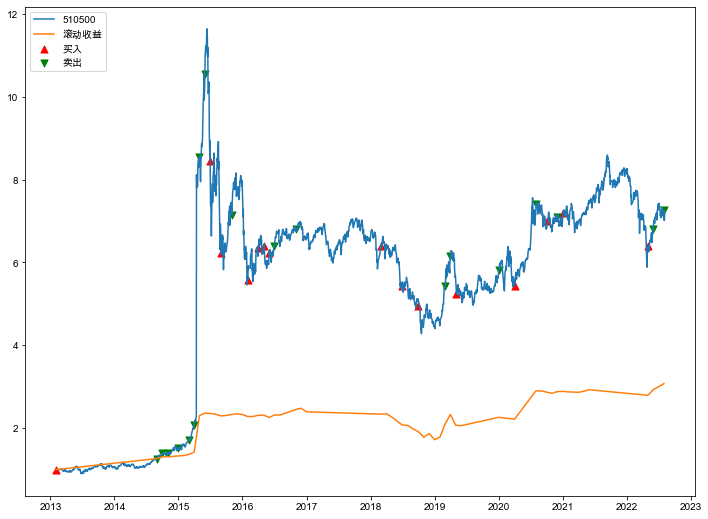

In [13]:
plt.rcParams["font.family"] = 'Arial Unicode MS'  # 设置字体，正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 设置字体，正常显示中文
plt.figure(figsize=(12, 9))

plt.plot(
    fund_for_plt['净值日期'],
    fund_for_plt['单位净值'] / for_plt.loc[0, '单位净值'],
    label=fund_code,
)
plt.plot(
    for_plt['净值日期'],
    for_plt['总资产'] / init_shares,
    label='滚动收益',
)


plt.scatter(
    buy_op_df['净值日期'],
    buy_op_df['单位净值'] / for_plt.loc[0, '单位净值'],
    c='r',
    s=50,
    marker='^',
    label='买入',
)
plt.scatter(
    sell_op_df['净值日期'],
    sell_op_df['单位净值'] / for_plt.loc[0, '单位净值'],
    c='g',
    s=50,
    marker='v',
    label='卖出',
)

plt.axis('tight')
legend(loc='upper left')